In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import roc_curve, auc



In [2]:
def XGB(X,y):
    #Train and valid split
    X_train,X_val,y_train,y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # XGB Classifier
    clf = xgb.XGBClassifier()
    y_train = y_train.values.ravel()
    clf.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred = clf.predict(X_val)
    
    #Probability estimates
    pred_probs = clf.predict_proba(X_val)
    
    
    #Model Evaultion Metrics
    accuracy = metrics.accuracy_score(y_val, y_pred)
    f1_score = metrics.f1_score(y_val, y_pred)
    precision = metrics.precision_score(y_val, y_pred)
    recall = metrics.recall_score(y_val, y_pred)
    cf_matrix = metrics.confusion_matrix(y_val,y_pred)
    
    probs_isgoal = pred_probs[:,1]
    roc_auc = metrics.roc_auc_score(y_val,probs_isgoal)
    
        
    return pred_probs, accuracy,f1_score, precision, recall, roc_auc, cf_matrix

In [3]:
# Read in data and assign X and y
data = pd.read_csv('../../data/train.csv', index_col=0)
X = data[data.columns.tolist()[:-1]]
y = data[['isGoal']]
X

,time,period,coordinateX,coordinateY,shotDistance,shotAngle,shotType,emptyNet,lastEventType,lastCoordinateX,lastCoordinateY,lastTime,lastShotDistance,rebound,changeShotAngle,speed,friendlyPlayersOnIce,opposingPlayersOnIce,timeSincePP
gameId,,,,,,,,,,,,,,,,,,,
2015020001,51,1,-55.0,6.0,34.5254,10.0080,6,0,5,94.0,-34.0,11,154.2757,0,0.0000,14.0251,5,5,0
2015020001,65,1,-79.0,0.0,10.0000,0.0000,3,0,3,-37.0,-28.0,7,50.4777,0,0.0000,7.2111,5,5,0
2015020001,66,1,-75.0,-1.0,14.0357,-4.0856,3,0,14,-79.0,0.0,1,4.1231,1,-4.0856,4.1231,5,5,0
2015020001,113,1,-55.0,-36.0,49.5177,-46.6366,6,0,5,-91.0,35.0,18,79.6053,0,0.0000,4.4225,5,5,0
2015020001,157,1,-61.0,-1.0,28.0179,-2.0454,4,0,1,-69.0,-22.0,5,22.4722,0,0.0000,4.4944,5,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018021271,3337,3,67.0,-19.0,29.0689,-40.8151,2,0,3,29.0,35.0,33,66.0303,0,0.0000,2.0009,5,5,0
2018021271,3393,3,-78.0,1.0,11.0454,5.1944,6,0,1,-69.0,-22.0,29,24.6982,0,0.0000,0.8517,5,5,0
2018021271,3519,3,-82.0,10.0,12.2066,55.0080,6,0,6,-71.0,4.0,19,12.5300,0,0.0000,0.6595,5,5,0


In [4]:
col_list = X.columns.to_list()
#print(col_list)
feature_names = np.array(X.columns.to_list())
print(feature_names)

['time' 'period' 'coordinateX' 'coordinateY' 'shotDistance' 'shotAngle'
 'shotType' 'emptyNet' 'lastEventType' 'lastCoordinateX' 'lastCoordinateY'
 'lastTime' 'lastShotDistance' 'rebound' 'changeShotAngle' 'speed'
 'friendlyPlayersOnIce' 'opposingPlayersOnIce' 'timeSincePP']


In [5]:
#Feature Selection: Univariate Feature Selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import chi2

min_max_scaler = MinMaxScaler()

tot_col = len(X.columns)


X = X.copy()
#for col in X:
    #X[[col]] = min_max_scaler.fit_transform(X[[col]])
X[col_list] = min_max_scaler.fit_transform(X[col_list])

#Findking the best k values
for k_value in range(10, tot_col):
    X_new = SelectKBest(chi2, k=k_value).fit_transform(X, y)
    pred_probs, accuracy,f1_score, precision, recall, roc_auc, cf_matrix = XGB(X_new, y)
    print(f' k: {k_value} accuracy: {accuracy: 6.4}, f1_score: {f1_score: 6.4}, precision: {precision :6.4},\
    recall: {recall: 6.4}, roc_auc: {roc_auc: 6.4}')

 k: 10 accuracy:  0.9046, f1_score:  0.1257, precision: 0.7718,    recall:  0.06844, roc_auc:  0.7755
 k: 11 accuracy:  0.9051, f1_score:  0.1311, precision: 0.7958,    recall:  0.07144, roc_auc:  0.7779
 k: 12 accuracy:  0.9049, f1_score:  0.1369, precision: 0.7592,    recall:  0.07523, roc_auc:  0.7904
 k: 13 accuracy:  0.9058, f1_score:  0.1519, precision: 0.7835,    recall:  0.08408, roc_auc:  0.7924
 k: 14 accuracy:  0.9068, f1_score:  0.1683, precision: 0.7997,    recall:  0.09404, roc_auc:  0.8004
 k: 15 accuracy:  0.9066, f1_score:  0.1717, precision: 0.7754,    recall:  0.09657, roc_auc:  0.8011
 k: 16 accuracy:  0.9061, f1_score:  0.1719, precision: 0.7437,    recall:  0.0972, roc_auc:  0.8022
 k: 17 accuracy:  0.9068, f1_score:  0.178, precision: 0.7684,    recall:  0.1007, roc_auc:  0.8035
 k: 18 accuracy:  0.9067, f1_score:  0.1733, precision: 0.7771,    recall:  0.09752, roc_auc:  0.8016


In [6]:
#Selected k=15 based on f1_score and roc_auc
k = 15
selector = SelectKBest(score_func=chi2, k=k)
fit = selector.fit(X, y)
features = fit.transform(X)

selected_features = (feature_names[fit.scores_.argsort()[::-1][:k]]).tolist()
print(f' Selected Features')
print(selected_features)

X_new = X[selected_features]
print('Shape of new X', X_new.shape)

features_dropped = set(col_list).difference(selected_features)
print('features_dropped: ', features_dropped)

pred_probs, accuracy,f1_score, precision, recall, roc_auc, cf_matrix = XGB(X_new, y)
print(f' accuracy: {accuracy}')
print(f' f1_score: {f1_score}')
print(f' precision: {precision}')
print(f' recall: {recall}')
print(f' roc_auc: {roc_auc}')
print(f' Confusion Matrix')
print(cf_matrix)

 Selected Features
['emptyNet', 'rebound', 'period', 'time', 'lastEventType', 'timeSincePP', 'shotDistance', 'lastTime', 'friendlyPlayersOnIce', 'opposingPlayersOnIce', 'speed', 'shotType', 'lastShotDistance', 'coordinateY', 'lastCoordinateY']
Shape of new X (315532, 15)
features_dropped:  {'changeShotAngle', 'coordinateX', 'lastCoordinateX', 'shotAngle'}
 accuracy: 0.9066189170773449
 f1_score: 0.17174982431482783
 precision: 0.7753807106598984
 recall: 0.0965702544649913
 roc_auc: 0.80112179066963
 Confusion Matrix
[[56603   177]
 [ 5716   611]]


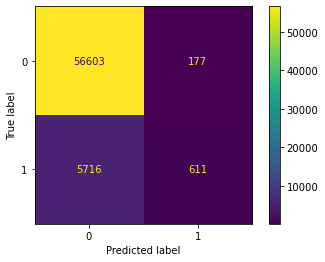

In [7]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix)
disp.plot()

In [8]:
#